 Import các thư viện cần thiết

In [1]:
import os
import re
import json
import time
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
import tensorflow as tf

from underthesea import word_tokenize
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
categories = ["cong-nghe","the-gioi","thoi-su","kinh-doanh",  "giai-tri", "the-thao", "phap-luat", "giao-duc", "suc-khoe", "gia-dinh", "du-lich", "oto-xe-may", "khoa-hoc", "tam-su", "cuoi"]

# Biến đếm số lượng bài viết (để tạo doc_id)
article_counter = 1

# Tạo session với cơ chế retry
session = requests.Session()
retry = Retry(
    total=5,  # Số lần thử lại tối đa
    backoff_factor=1,  # Thời gian chờ giữa các lần thử lại
    status_forcelist=[500, 502, 503, 504],  # Danh sách các mã trạng thái để thử lại
)
adapter = HTTPAdapter(max_retries=retry)
session.mount("http://", adapter)
session.mount("https://", adapter)

# Hàm lấy nội dung chi tiết của bài báo
def get_article_content(article_url):
    global article_counter
    try:
        response = session.get(article_url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Lấy tiêu đề bài báo
        title = soup.find("h1", class_="title-detail")
        if not title:
            return None
        
        title = title.text.strip()
        
        # Lấy ngày đăng
        date_tag = soup.find("span", class_="date")
        if date_tag:
            date = date_tag.text.strip()
        else:
            date = "Unknown"

        # Lấy nội dung bài báo
        paragraphs = soup.find_all("p", class_="Normal")
        content = " ".join([p.text for p in paragraphs])
        
        # Định dạng doc_id
        doc_id = f"news-{article_counter:05d}"
        article_counter += 1

        return {
            "doc_id": doc_id,
            "content": content,
            "label": "True",  # Vì đây là tin thật từ báo chính thống
            "source": "VNExpress",
            "date": date,
            "sentiment": "<True>"
        }
    except Exception as e:
        print(f"Lỗi lấy bài viết: {article_url} - {e}")
        return None

# Hàm lấy danh sách bài viết từ chuyên mục
def get_news_from_category(category):
    base_url = f"https://vnexpress.net/{category}"
    response = session.get(base_url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(response.text, 'html.parser')

    articles = []
    for article in soup.find_all("h3", class_="title-news"):
        try:
            link = article.find("a")["href"]
            if "https://" not in link:
                link = "https://vnexpress.net" + link  # Chuyển link tương đối thành link tuyệt đối
            
            article_data = get_article_content(link)
            if article_data:
                articles.append(article_data)
            
            time.sleep(1)  # Tránh bị chặn khi request quá nhanh
        except Exception as e:
            print(f"Lỗi lấy link bài viết: {e}")

    return articles

# Lưu dữ liệu vào file JSON
all_news = []
for category in categories:
    print(f"Đang lấy dữ liệu từ chuyên mục: {category}")
    all_news.extend(get_news_from_category(category))

with open("C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json", "w", encoding="utf-8") as f:
    json.dump(all_news, f, ensure_ascii=False, indent=4)

print(f"Đã thu thập {len(all_news)} bài báo và lưu vào vnexpress_news.json")

Đang lấy dữ liệu từ chuyên mục: cong-nghe
Đang lấy dữ liệu từ chuyên mục: the-gioi
Đang lấy dữ liệu từ chuyên mục: thoi-su
Đang lấy dữ liệu từ chuyên mục: kinh-doanh
Đang lấy dữ liệu từ chuyên mục: giai-tri
Đang lấy dữ liệu từ chuyên mục: the-thao
Đang lấy dữ liệu từ chuyên mục: phap-luat
Đang lấy dữ liệu từ chuyên mục: giao-duc
Đang lấy dữ liệu từ chuyên mục: suc-khoe
Đang lấy dữ liệu từ chuyên mục: gia-dinh
Đang lấy dữ liệu từ chuyên mục: du-lich
Đang lấy dữ liệu từ chuyên mục: oto-xe-may
Đang lấy dữ liệu từ chuyên mục: khoa-hoc
Đang lấy dữ liệu từ chuyên mục: tam-su
Đang lấy dữ liệu từ chuyên mục: cuoi
Đã thu thập 640 bài báo và lưu vào vnexpress_news.json


In [3]:
def random_number(match):
    """Tạo một số ngẫu nhiên có cùng số chữ số, hỗ trợ số âm và thập phân."""
    num_str = match.group()
    if '.' in num_str:  # Số thập phân
        int_part, dec_part = num_str.split('.')
        int_part = str(random.randint(10**(len(int_part)-1), 10**len(int_part) - 1))
        dec_part = str(random.randint(10**(len(dec_part)-1), 10**len(dec_part) - 1))
        return f"{int_part}.{dec_part}"
    elif '-' in num_str:  # Số âm
        num_str = num_str.lstrip('-')
        return f"-{random.randint(10**(len(num_str)-1), 10**len(num_str) - 1)}"
    else:  # Số nguyên dương
        return str(random.randint(10**(len(num_str)-1), 10**len(num_str) - 1))

def replace_numbers(text):
    """Thay thế tất cả số trong chuỗi bằng số ngẫu nhiên giữ nguyên số chữ số."""
    return re.sub(r'(?<!\d/\d/\d\d\d\d\b)(?<!\d/\d/\d\d\d\d,\s)(\b-?\d+(\.\d+)?\b)', random_number, text)

def process_json(data):
    """Chỉ thay đổi phần 'content' trong JSON và thêm label, sentiment."""
    if isinstance(data, dict):  # Nếu là dictionary
        if "content" in data and isinstance(data["content"], str):
            data["content"] = replace_numbers(data["content"])
            # Thêm các trường mới
            data["label"] = "Fake"
            data["sentiment"] = "<Fake>"
        # Đệ quy xử lý các trường hợp lồng nhau (nếu có)
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                process_json(value)
    elif isinstance(data, list):  # Nếu là list
        for item in data:
            process_json(item)
    return data

def process_json_file(input_file, output_file):
    try:
        with open(input_file, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Chỉ thay đổi phần 'content' và thêm các trường mới
        processed_data = process_json(data)

        with open(output_file, 'w', encoding='utf-8') as file:
            json.dump(processed_data, file, ensure_ascii=False, indent=4)

        print(f"Processed file saved to {output_file}")
    except Exception as e:
        print(f"Error: {e}")

# Thay đổi tên file phù hợp
input_file = "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json"
output_file = "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_fakenews_today.json"
process_json_file(input_file, output_file)

Processed file saved to C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_fakenews_today.json


In [4]:
def random_number(match):
    """Tạo một số ngẫu nhiên có cùng số chữ số, hỗ trợ số âm và thập phân."""
    num_str = match.group()
    if '.' in num_str:  # Số thập phân
        int_part, dec_part = num_str.split('.')
        int_part = str(random.randint(10**(len(int_part)-1), 10**len(int_part) - 1))
        dec_part = str(random.randint(10**(len(dec_part)-1), 10**len(dec_part) - 1))
        return f"{int_part}.{dec_part}"
    elif '-' in num_str:  # Số âm
        num_str = num_str.lstrip('-')
        return f"-{random.randint(10**(len(num_str)-1), 10**len(num_str) - 1)}"
    else:  # Số nguyên dương
        return str(random.randint(10**(len(num_str)-1), 10**len(num_str) - 1))

def replace_numbers(text):
    """Thay thế ngẫu nhiên 50% số trong chuỗi bằng số ngẫu nhiên."""
    def conditional_replace(match):
        # Ngẫu nhiên quyết định xem có thay đổi số này không (50% cơ hội)
        if random.random() < 0.5:
            return random_number(match)
        return match.group()  # Giữ nguyên số gốc nếu không thay đổi
    
    # Chỉ thay đổi các số độc lập, không thay đổi số trong định dạng ngày giờ
    return re.sub(r'(?<!\d/\d/\d\d\d\d\b)(?<!\d/\d/\d\d\d\d,\s)(\b-?\d+(\.\d+)?\b)', 
                 conditional_replace, text)

def process_json(data):
    """Chỉ thay đổi phần 'content' trong JSON và thêm label, sentiment."""
    if isinstance(data, dict):  # Nếu là dictionary
        if "content" in data and isinstance(data["content"], str):
            data["content"] = replace_numbers(data["content"])
            # Thêm các trường mới cho dữ liệu nửa thật nửa giả
            data["label"] = "Half-true"
            data["sentiment"] = "<Half-true>"
        # Đệ quy xử lý các trường hợp lồng nhau (nếu có)
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                process_json(value)
    elif isinstance(data, list):  # Nếu là list
        for item in data:
            process_json(item)
    return data

def process_json_file(input_file, output_file):
    try:
        with open(input_file, 'r', encoding='utf-8') as file:
            data = json.load(file)

        # Chỉ thay đổi phần 'content' và thêm các trường mới
        processed_data = process_json(data)

        with open(output_file, 'w', encoding='utf-8') as file:
            json.dump(processed_data, file, ensure_ascii=False, indent=4)

        print(f"Processed file saved to {output_file}")
    except Exception as e:
        print(f"Error: {e}")

# Thay đổi tên file phù hợp
input_file = "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json"
output_file = "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_Half-true_today.json"
process_json_file(input_file, output_file)

Processed file saved to C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_Half-true_today.json


In [5]:
source_files = {
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json": "C:/Users/ADMIN/OneDrive/Desktop/NLP/true_news.json",
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_Half-true_today.json": "C:/Users/ADMIN/OneDrive/Desktop/NLP/half_true_news.json",
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_fakenews_today.json": "C:/Users/ADMIN/OneDrive/Desktop/NLP/fake_news.json"
}

def merge_json_files(source_path, target_path):
    """Gộp dữ liệu từ file nguồn vào file đích."""
    try:
        # Load dữ liệu từ file nguồn (nếu tồn tại)
        if os.path.exists(source_path):
            with open(source_path, 'r', encoding='utf-8') as source_file:
                source_data = json.load(source_file)
        else:
            source_data = []
            print(f"File không tồn tại: {source_path}")

        # Load dữ liệu từ file đích (nếu tồn tại), nếu không thì tạo mới
        if os.path.exists(target_path):
            with open(target_path, 'r', encoding='utf-8') as target_file:
                target_data = json.load(target_file)
        else:
            target_data = []
            print(f"File đích không tồn tại, sẽ tạo mới: {target_path}")

        # Gộp dữ liệu (giả sử dữ liệu là list)
        if isinstance(source_data, list) and isinstance(target_data, list):
            merged_data = target_data + source_data
        else:
            raise ValueError(f"Dữ liệu trong {source_path} hoặc {target_path} không phải là list")

        # Ghi dữ liệu đã gộp vào file đích
        with open(target_path, 'w', encoding='utf-8') as target_file:
            json.dump(merged_data, target_file, ensure_ascii=False, indent=4)

        print(f"Đã gộp {source_path} vào {target_path}")

        # Xóa file nguồn sau khi gộp
        os.remove(source_path)
        print(f"Đã xóa file nguồn: {source_path}")

    except Exception as e:
        print(f"Lỗi khi xử lý {source_path}: {e}")

# Thực hiện gộp và xóa cho từng cặp file
for source, target in source_files.items():
    merge_json_files(source, target)

print("Hoàn tất quá trình gộp và xóa file!")

Đã gộp C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json vào C:/Users/ADMIN/OneDrive/Desktop/NLP/true_news.json
Đã xóa file nguồn: C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_news_today.json
Đã gộp C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_Half-true_today.json vào C:/Users/ADMIN/OneDrive/Desktop/NLP/half_true_news.json
Đã xóa file nguồn: C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_Half-true_today.json
Đã gộp C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_fakenews_today.json vào C:/Users/ADMIN/OneDrive/Desktop/NLP/fake_news.json
Đã xóa file nguồn: C:/Users/ADMIN/OneDrive/Desktop/NLP/vnexpress_fakenews_today.json
Hoàn tất quá trình gộp và xóa file!


 TẢI STOPWORDS

In [6]:
def download_stopwords(stop_words_url, file_name):
    """Tải stopwords từ URL nếu file chưa tồn tại."""
    if not os.path.exists(file_name):
        try:
            r = requests.get(stop_words_url)
            r.raise_for_status()
            with open(file_name, 'wb') as f:
                f.write(r.content)
            print(f"Stopwords downloaded successfully: {file_name}")
        except requests.RequestException as e:
            print(f"Error fetching stopwords: {e}")
            return []
    return load_stopwords(file_name)

def load_stopwords(file_name):
    """Đọc stopwords từ file."""
    if os.path.exists(file_name):
        with open(file_name, 'r', encoding='utf-8') as f:
            stop_words = f.read().splitlines()
        print(f"Number of stop words: {len(stop_words)}")
        return stop_words
    else:
        print(f"Stopwords file not found: {file_name}")
        return []

STOPWORDS_URL = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords.txt'
STOPWORDS_FILE = 'vietnamese-stopwords.txt'
stop_words = download_stopwords(STOPWORDS_URL, STOPWORDS_FILE)

Number of stop words: 1942


 HÀM LÀM SẠCH VĂN BẢN

In [7]:
def clean_text(text):
    """Làm sạch văn bản: xóa ký tự đặc biệt, chữ số, chuyển về chữ thường."""
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

 ĐỌC FILE JSON

In [8]:
def clean_text(text):
    """Hàm làm sạch văn bản nếu cần"""
    text = text.replace("\n", " ").strip()
    return text

def get_json_data(file_path):
    """Đọc file JSON và xử lý để lấy dữ liệu từ tin tức"""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return pd.DataFrame(columns=["doc_id", "content", "source", "date", "sentiment"])

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error loading JSON file: {e}")
        return pd.DataFrame(columns=["doc_id", "content", "source", "date", "sentiment"])

    news_data = []

    for item in data:
        doc_id = item.get("doc_id", "")
        content = clean_text(item.get("content", ""))
        source = item.get("source", "")
        date = item.get("date", "")
        sentiment = item.get("sentiment", "")

        if content:
            news_data.append([doc_id, content, source, date, sentiment])

    return pd.DataFrame(news_data, columns=["doc_id", "content", "source", "date", "sentiment"])

# Đọc dữ liệu từ file JSON
file_path = "/mnt/data/true_news.json"
df = get_json_data(file_path)
print(df.head())  


File not found: /mnt/data/true_news.json
Empty DataFrame
Columns: [doc_id, content, source, date, sentiment]
Index: []


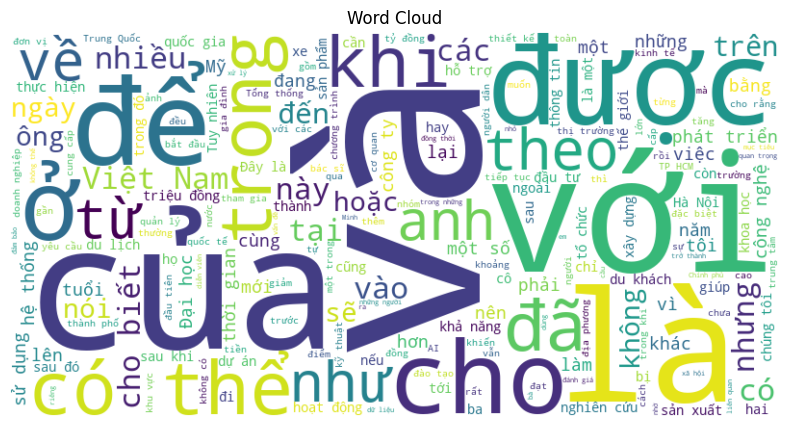

In [9]:
# Import các thư viện cần thiết
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Giả sử bạn đã có dữ liệu văn bản trong biến `all_news`
# Kiểm tra dữ liệu đầu vào
if not all_news:
    raise ValueError("Dữ liệu văn bản trống. Vui lòng kiểm tra lại biến `all_news`.")

# Kết hợp tất cả các văn bản thành một chuỗi lớn
text_data = " ".join([news['content'] for news in all_news])

# Tạo word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

# Hiển thị word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

XỬ LÝ STOPWORDS VÀ TOKENIZATION

In [10]:
def remove_stopwords(text):
    """Loại bỏ stopwords từ văn bản."""
    return ' '.join([word for word in text.split() if word not in stop_words])

def tokenize(text):
    """Tokenize văn bản."""
    try:
        return word_tokenize(text, format="text")
    except Exception as e:
        print(f"Tokenization error: {e}")
        return text

CHUẨN BỊ DỮ LIỆU

In [11]:
# Đọc dữ liệu từ file JSON
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Gộp dữ liệu từ nhiều file JSON
def merge_json_files(file_paths):
    merged_data = []
    for file_path in file_paths:
        data = load_data(file_path)
        merged_data.extend(data)
    return merged_data

# Lưu dữ liệu gộp vào một file JSON
def save_to_json(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

file_paths = [
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/half_true_news.json",
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/true_news.json",
    "C:/Users/ADMIN/OneDrive/Desktop/NLP/fake_news.json"

]

merged_data = merge_json_files(file_paths)

save_to_json("C:/Users/ADMIN/OneDrive/Desktop/NLP/data_new.json", merged_data)

print("Data merged and saved to /content/data_new.json")


Data merged and saved to /content/data_new.json


In [12]:
def prepare_data(*file_paths):
    """Đọc và hợp nhất dữ liệu từ nhiều file JSON."""
    dataframes = [get_json_data(file) for file in file_paths]
    combined_data = pd.concat(dataframes, ignore_index=True)
    combined_data = combined_data[combined_data['sentiment'].notna()]
    # Thay đổi 'text' thành 'content'
    combined_data['tokenized_text'] = combined_data['content'].apply(tokenize).apply(remove_stopwords)
    return combined_data

# Chuẩn bị dữ liệu
sen_data = prepare_data( "C:/Users/ADMIN/OneDrive/Desktop/NLP/half_true_news.json","C:/Users/ADMIN/OneDrive/Desktop/NLP/true_news.json","C:/Users/ADMIN/OneDrive/Desktop/NLP/fake_news.json")

In [13]:
file_path = "C:/Users/ADMIN/OneDrive/Desktop/NLP/data_new.json"

# Danh sách để lưu trữ các nhãn
label_list = []

try:
    # Mở và đọc file JSON
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # Duyệt qua từng tin tức và lấy nhãn
    for news in data:
        label_list.append(news.get("label", "Unknown"))

except FileNotFoundError:
    print(f"File not found: {file_path}")
except json.JSONDecodeError:
    print(f"Error decoding JSON in file: {file_path}")

# Đếm số lượng tin tức theo nhãn
label_counts = Counter(label_list)

print("Số lượng tin tức thuộc từng nhóm:")
for label, count in label_counts.items():
    print(f"{label}: {count}")


Số lượng tin tức thuộc từng nhóm:
Half-true: 8649
True: 8420
Fake: 8649


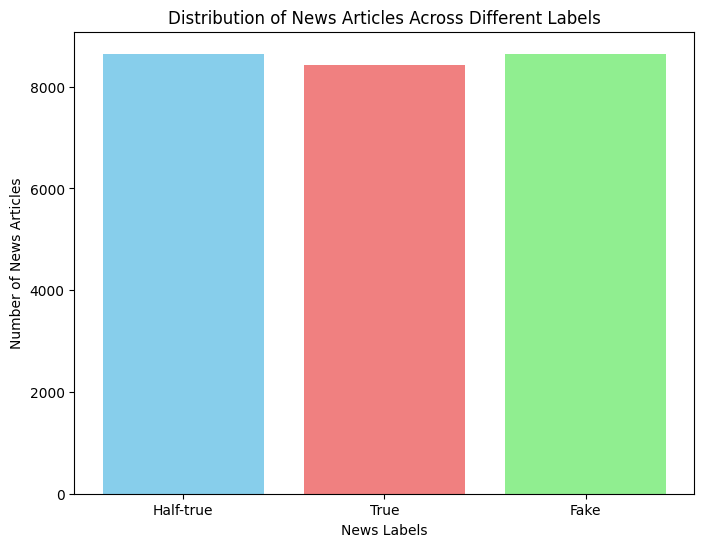

In [14]:
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral', 'lightgreen'])  # Example colors
plt.xlabel("News Labels")
plt.ylabel("Number of News Articles")
plt.title("Distribution of News Articles Across Different Labels")
plt.show()

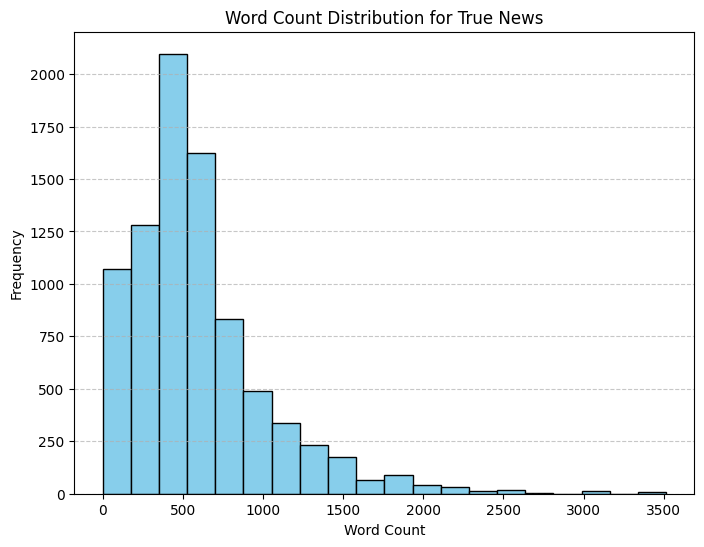

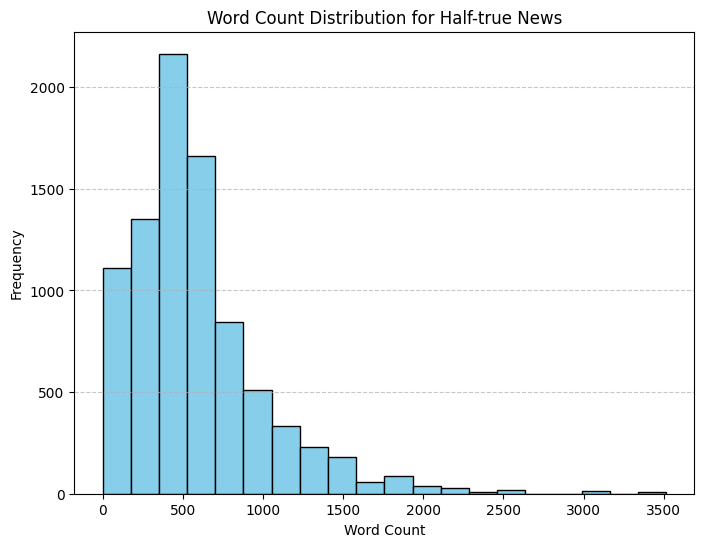

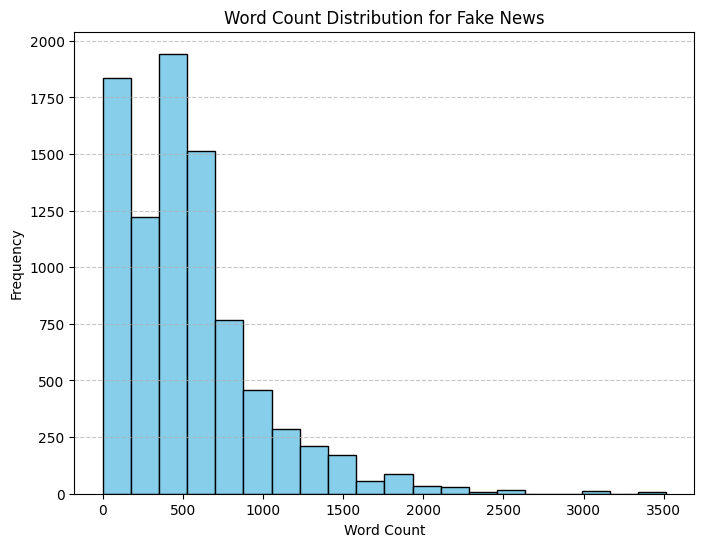

In [15]:
# Đường dẫn đến file JSON
file_path = "C:/Users/ADMIN/OneDrive/Desktop/NLP/data_new.json"

# Load dữ liệu từ file JSON
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Trích xuất số lượng từ theo nhãn
def extract_word_counts_by_label(data):
    word_counts = {"True": [], "Half-true": [], "Fake": []}
    for news in data:
        label = news.get("label", "Unknown")
        if label in word_counts:
            word_counts[label].append(len(news.get("content", "").split()))
    return word_counts

# Vẽ biểu đồ phân bố số lượng từ
def plot_histograms(word_counts):
    for label, counts in word_counts.items():
        plt.figure(figsize=(8, 6))
        plt.hist(counts, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Word Count Distribution for {label} News')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# Xử lý dữ liệu
data = load_data(file_path)
word_counts = extract_word_counts_by_label(data)
plot_histograms(word_counts)


In [16]:
# Hàm tải dữ liệu từ file JSON
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Hàm tìm tin tức có nội dung dài nhất và ngắn nhất
def find_longest_and_shortest_news(data):
    longest_news = ""
    shortest_news = " " * 1000

    for news in data:
        content = news.get('content', "")
        if len(content) > len(longest_news):
            longest_news = content
        if len(content) < len(shortest_news) and content.strip():
            shortest_news = content

    return longest_news, shortest_news

file_paths = ["C:/Users/ADMIN/OneDrive/Desktop/NLP/data_new.json"]

all_data = []
for file_path in file_paths:
    data = load_data(file_path)
    all_data.extend(data)

# Tìm nội dung tin tức dài nhất và ngắn nhất
longest, shortest = find_longest_and_shortest_news(all_data)

print("Longest news:", longest)
print("Shortest news:", shortest)


Longest news: Club Brugge - Aston Villa: 0h45 thứ Tư ngày 6/8, giờ Hà Nội Ở lượt bốn vòng bảng mùa này, Club Brugge hạ Aston Villa 1-3, dứt chuỗi 91 trận không thắng trước các đội bóng Anh tại các cup châu Âu.  Sau khi kết thúc giai đoạn vòng bảng, họ đứng thứ 59 - suất cuối cùng được đá play-off tranh vé vào vòng 8/5. Tại đây, đội bóng của Bỉ thắng vang dội Atalanta - nhà vô địch Europa League 2023-2024 - với tổng tỷ số 5-2. "Nếu chúng tôi tiếp tục chơi ở đẳng cấp cao như vậy, mọi thứ đều có thể xảy ra", tiền vệ Ardon Jashari nói trước trận lượt đi vòng 2/1 tuần này trên sân nhà Jan Breydel. Ở chiều ngược lại, sau thất bại trên sân của Club Brugge, Aston Villa chỉ thua thêm một trận rồi cán đích trong top 8, giành vé trực tiếp vào vòng 1/4.  Được trang bị những bài học từ cuộc đối đầu gần nhất, Emery đặt mục tiêu thắng lượt đi hôm nay để nắm lợi thế trước màn tái đấu trên sân nhà Villa Park. "Trận thua đó là thông tin tốt cho chúng tôi", HLV người Tây Ban Nha bày tỏ. "Nó cho chúng tôi

Trích xuât đặc trưng

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Hàm trích xuất đặc trưng TF-IDF
def extract_tfidf_features(X_train, X_dev, X_test, output_path="tfidf_vectorizer.pkl"):
    # Khởi tạo TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Có thể tùy chỉnh tham số

    # Fit và transform trên tập train
    X_train_tfidf = vectorizer.fit_transform(X_train)

    # Chỉ transform trên tập dev và test
    X_dev_tfidf = vectorizer.transform(X_dev)
    X_test_tfidf = vectorizer.transform(X_test)

    # Kiểm tra shape của ma trận TF-IDF
    print(f"Shape of TF-IDF matrix (train): {X_train_tfidf.shape}")
    print(f"Shape of TF-IDF matrix (dev): {X_dev_tfidf.shape}")
    print(f"Shape of TF-IDF matrix (test): {X_test_tfidf.shape}")

    # Lưu vectorizer để sử dụng lại (dự đoán mẫu mới)
    with open(output_path, 'wb') as f:
        pickle.dump(vectorizer, f)

    return X_train_tfidf, X_dev_tfidf, X_test_tfidf, vectorizer

# Giả sử bạn đã có X_train, X_dev, X_test (dữ liệu văn bản đã được tiền xử lý)
# Ví dụ chạy hàm:
# X_train_tfidf, X_dev_tfidf, X_test_tfidf, vectorizer = extract_tfidf_features(X_train, X_dev, X_test)

TRAIN/TEST SPLIT

In [18]:
X = sen_data['tokenized_text']
y = sen_data['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# In kích thước của từng tập
print(f"Train size: {len(X_train)}")
print(f"Dev size: {len(X_dev)}")
print(f"Test size: {len(X_test)}")

Train size: 17894
Dev size: 3834
Test size: 3835


Naive Bayes

In [19]:
X_train_tfidf, X_dev_tfidf, X_test_tfidf, vectorizer = extract_tfidf_features(X_train, X_dev, X_test)

Shape of TF-IDF matrix (train): (17894, 5000)
Shape of TF-IDF matrix (dev): (3834, 5000)
Shape of TF-IDF matrix (test): (3835, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# Hàm huấn luyện và đánh giá mô hình
def train_and_evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test):
    # Khởi tạo và huấn luyện mô hình Naive Bayes
    nb_clf = MultinomialNB(alpha=0.1)  # Có thể tùy chỉnh alpha
    nb_clf.fit(X_train_tfidf, y_train)

    # Dự đoán trên tập test
    nb_preds = nb_clf.predict(X_test_tfidf)

    # Đánh giá mô hình
    print("Đánh giá mô hình Naive Bayes:")
    print(classification_report(y_test, nb_preds, digits=4))

    # Hiển thị confusion matrix
    cm_nb = confusion_matrix(y_test, nb_preds, labels=nb_clf.classes_)
    disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_clf.classes_)
    disp_nb.plot()
    plt.show()

    return nb_clf

# Hàm dự đoán mẫu mới
def predict_samples_nb(samples, vectorizer_path="tfidf_vectorizer.pkl", model=None):
    # Tải vectorizer đã lưu
    with open(vectorizer_path, 'rb') as f:
        vectorizer = pickle.load(f)

    # Tiền xử lý mẫu mới (giả sử bạn đã định nghĩa các hàm này)
    processed_samples = [remove_stopwords(clean_text(s)) for s in samples]
    sample_vectors = vectorizer.transform(processed_samples)

    # Dự đoán
    predictions = model.predict(sample_vectors)
    return predictions



Đánh giá mô hình Naive Bayes:
              precision    recall  f1-score   support

      <Fake>     0.4429    0.3336    0.3805      1325
 <Half-true>     0.3218    0.3978    0.3558      1282
      <True>     0.4065    0.4145    0.4105      1228

    accuracy                         0.3810      3835
   macro avg     0.3904    0.3820    0.3823      3835
weighted avg     0.3908    0.3810    0.3818      3835



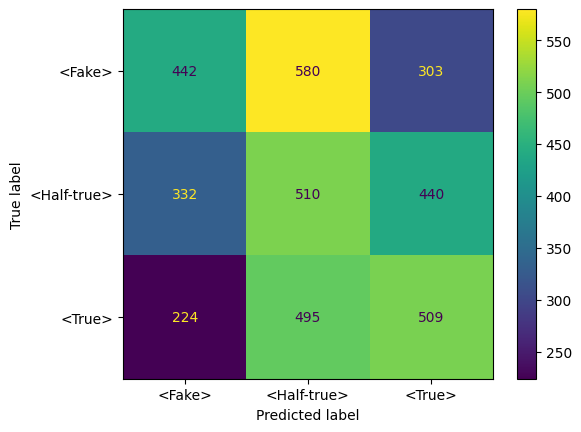

Dự đoán: ['<True>']


In [21]:
nb_model = train_and_evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test)
new_samples = ["Bình Minh (Tổng hợp)"]
predictions = predict_samples_nb(new_samples, model=nb_model)
print("Dự đoán:", predictions)

Logistic Regression:

In [22]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

# Huấn luyện mô hình Logistic Regression
clf = LogisticRegression(max_iter=1000) # Now you can use LogisticRegression
clf.fit(X_train_tfidf, y_train)

# Dự đoán trên tập test
preds = clf.predict(X_test_tfidf)

# Đánh giá mô hình
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

      <Fake>     0.6017    0.6430    0.6217      1325
 <Half-true>     0.3881    0.3167    0.3488      1282
      <True>     0.5929    0.6629    0.6259      1228

    accuracy                         0.5403      3835
   macro avg     0.5276    0.5409    0.5321      3835
weighted avg     0.5275    0.5403    0.5318      3835



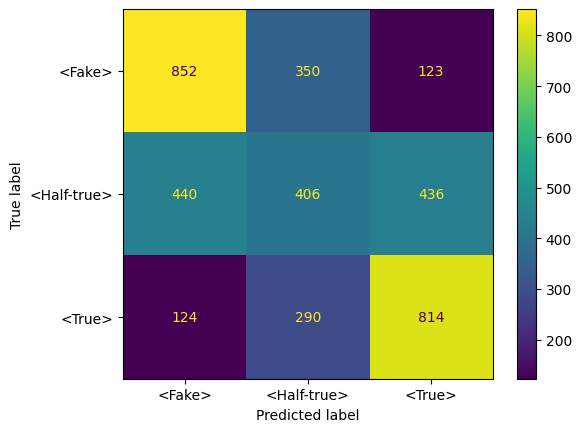

In [23]:
cm = confusion_matrix(y_test, preds, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

thuc te


In [24]:
def predict_samples(samples):
    processed_samples = [remove_stopwords(clean_text(s)) for s in samples]
    sample_vectors = vectorizer.transform(processed_samples)
    predictions = clf.predict(sample_vectors)
    return predictions

new_samples = [" Quan trọng hơn, đến nay chúng tôi vẫn chưa có kế hoạch cụ thể cho đám cưới. Tôi đã thẳng thắn chia sẻ với anh về những lo lắng của mình, nhưng mọi thứ vẫn chưa có hướng giải quyết rõ ràng. Trước những khó khăn này, tôi bắt đầu tự hỏi: Liệu mình có nên tiếp tục chờ đợi hay tìm hiểu một người khác phù hợp hơn? Thùy Nhi"]
predictions = predict_samples(new_samples)
print(predictions)

['<Fake>']


BiLSTM

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.3680 - loss: 1.0756 - val_accuracy: 0.4528 - val_loss: 1.0017
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.4712 - loss: 0.9839 - val_accuracy: 0.4784 - val_loss: 0.9504
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.5369 - loss: 0.8828 - val_accuracy: 0.4898 - val_loss: 0.9317
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.5596 - loss: 0.8395 - val_accuracy: 0.4885 - val_loss: 0.9254
Epoch 5/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.5986 - loss: 0.7898 - val_accuracy: 0.4984 - val_loss: 0.9333
Epoch 6/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.6131 - loss: 0.7594 - val_accuracy: 0.4990 - val_loss: 0.9414
Epoch 7/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.6190 - loss: 0.7501 - val_accuracy: 0.5556 - val_loss: 0.8799
Epoch 8/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - accuracy: 0.6592 - loss: 0.6879 - 

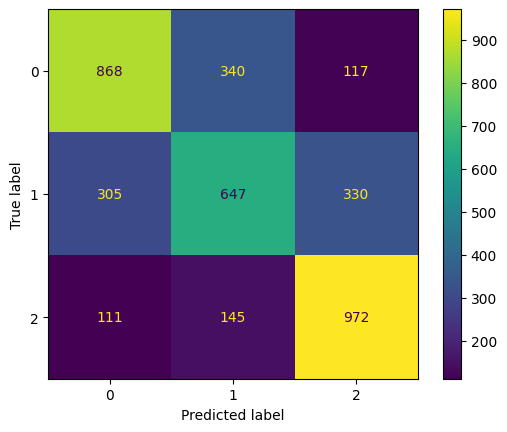

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


['True']

In [25]:
# code model BiLSTM
# BiLSTM Model
# Chuẩn bị dữ liệu cho BiLSTM
max_words = 10000  # Số lượng từ vựng tối đa
max_len = 200       # Độ dài tối đa của chuỗi

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sen_data['tokenized_text'])

X = tokenizer.texts_to_sequences(sen_data['tokenized_text'])
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(sen_data['sentiment']).values #one-hot encode

# Chia tập dữ liệu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Xây dựng mô hình BiLSTM
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(3, activation='softmax')) # Output layer with softmax

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_dev, y_dev))

# Đánh giá mô hình
_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


def predict_samples_bilstm(samples):
    processed_samples = [remove_stopwords(clean_text(s)) for s in samples]
    sequences = tokenizer.texts_to_sequences(processed_samples)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    predicted_classes = np.argmax(predictions, axis=1)
    # Map predicted class indices back to sentiment labels
    sentiment_labels = {0: 'Fake', 1: 'Half-true', 2: 'True'} # Assuming class order
    predicted_sentiments = [sentiment_labels[idx] for idx in predicted_classes]

    return predicted_sentiments

new_samples = ["Tôi sinh năm 1993, còn bạn trai tôi sinh năm 1995, là Việt kiều. Bố mẹ và họ hàng anh khác vùng miền với tôi, đang sinh sống và làm việc tại Ba Lan. Chúng tôi quen nhau qua công việc và đã hẹn hò được ba năm tại TP HCM, trong đó có một năm yêu xa vì anh phải về nước với lý do chăm sóc bố bị bệnh. Tuy nhiên, tôi cảm nhận đây chỉ là cái cớ gia đình anh đưa ra, nhằm tách chúng tôi, họ nghĩ rằng khoảng cách sẽ khiến mối quan hệ này tự nhiên rạn nứt. Khi về Ba Lan, sức khỏe của bố anh vẫn bình thường, không nghiêm trọng như gia đình anh từng nói trước đó. Trong suốt thời gian yêu nhau, gia đình anh luôn phản đối mối quan hệ này, đặc biệt là mẹ anh, bà muốn con dâu tương lai cùng vùng miền như gia đình bà để dễ hòa hợp nhiều mặt, đồng thời cũng đề cao yếu tố \"môn đăng hộ đối\". Tuy nhiên, nếu xét về hoàn cảnh gia đình, tôi không nghĩ mình có điểm nào kém họ. Gia đình tôi đã ổn định từ lâu, sở hữu nhà ở quận trung tâm, có cửa hàng kinh doanh trang trí nội thất hơn 20 năm và cho thuê nhà. Ngoài ra, gia đình và người thân tôi đã định cư tại San Francisco (Mỹ) hơn 30 năm nay. Dù bị gia đình phản đối và liên tục bị giới thiệu cho nhiều người khác, bạn trai tôi vẫn khẳng định với họ rằng anh đã có tôi. Sau một năm yêu xa, vào dịp tết vừa rồi, anh quay về Việt Nam và cầu hôn tôi. Gia đình và bạn bè anh đều biết về chuyện này. Tuy nhiên, mẹ anh vẫn tiếp tục gây khó dễ, khiến chúng tôi rất mệt mỏi mỗi khi về nhà bà chơi. Tôi đã nhiều lần cố gắng kết nối và trò chuyện với gia đình anh, nhưng họ không thực sự đón nhận tôi. Anh cũng hiểu rõ điều này. Bên cạnh đó, tôi còn lo lắng về tương lai nếu kết hôn và theo anh sang Ba Lan. Việc phải học tiếng Ba Lan để thích nghi với cuộc sống mới là một thách thức đối với tôi. Tôi cũng không muốn sống chung với gia đình anh sau khi kết hôn, bởi không cảm thấy mình được chào đón. Tuy nhiên, hiện tại anh vẫn chưa đủ kinh tế để ra riêng. Quan trọng hơn, đến nay chúng tôi vẫn chưa có kế hoạch cụ thể cho đám cưới. Tôi đã thẳng thắn chia sẻ với anh về những lo lắng của mình, nhưng mọi thứ vẫn chưa có hướng giải quyết rõ ràng. Trước những khó khăn này, tôi bắt đầu tự hỏi: Liệu mình có nên tiếp tục chờ đợi hay tìm hiểu một người khác phù hợp hơn? Thùy Nhi"]
predictions = predict_samples_bilstm(new_samples)
predictions


PhoBERT

In [26]:
#  code model PhoBERT
# Load PhoBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = TFAutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3) 

# Example usage (replace with your actual data)
def predict_samples_phobert(samples):
    inputs = tokenizer(samples, padding=True, truncation=True, return_tensors="tf")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_ids = tf.argmax(logits, axis=1).numpy()
    # Assuming class order
    sentiment_labels = {0: 'Fake', 1: 'Half-true', 2: 'True'}
    predicted_sentiments = [sentiment_labels[idx] for idx in predicted_class_ids]
    return predicted_sentiments

new_samples = ["Bình Minh (Tổng hợp)"]
predictions = predict_samples_phobert(new_samples)
predictions


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['Fake']

Đánh giá mô hình SVM:
              precision    recall  f1-score   support

           0     0.5591    0.5426    0.5507      1325
           1     0.3758    0.3682    0.3719      1282
           2     0.5205    0.5480    0.5339      1228

    accuracy                         0.4860      3835
   macro avg     0.4851    0.4863    0.4855      3835
weighted avg     0.4855    0.4860    0.4856      3835



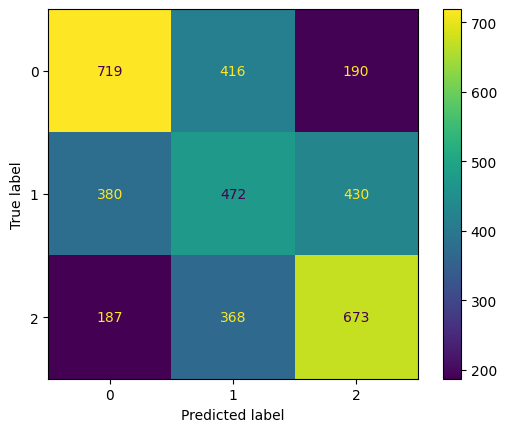

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Chuyển đổi y_train và y_test từ one-hot encoding sang nhãn lớp
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Huấn luyện mô hình SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train_tfidf, y_train_labels)

# Dự đoán trên tập test
svm_preds = svm_clf.predict(X_test_tfidf)

# Đánh giá mô hình
print("Đánh giá mô hình SVM:")
print(classification_report(y_test_labels, svm_preds, digits=4))

# Hiển thị confusion matrix
cm_svm = confusion_matrix(y_test_labels, svm_preds, labels=svm_clf.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_clf.classes_)
disp_svm.plot()
plt.show()